# 1. 목표
- Fashion MNIST dataset으로 Multi-Layer Perceptron (MLP) 모델 개발 / 학습 해보기
- TensorBoard로 학습된 모델 평가하기

# 2. MLP 모델 개발 및 학습
https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html

## 2.1 시작하기
- 수치계산을 위한 numpy, 그래프를 그리기 위한 matplotlib와 함께 PyTorch사용한 모델 개발에 필요한 모듈을 import합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F

- 학습에 사용할 장비가 CPU인지 GPU (cuda)인지 확인합니다.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


## 2.2 Dataset 준비하기

- torchvision.datasets에 연구용으로 자주 사용하는 데이터를 쉽게 불러올 수 있도록 제공하고 있습니다.

In [3]:
train_data = datasets.FashionMNIST(
    root="/home/jovyan/mlops-kubeflow/data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="/home/jovyan/mlops-kubeflow/data/FashionMNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

- Datasets를 DataLoader를 통해 batch 단위로 iterable한 객체로 분리합니다.

In [4]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for (x_train, y_train) in train_dataloader:
    print("Shape of X [N, C, H, W]: ", x_train.shape)
    print("Shape of y: ", y_train.shape, y_train.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64


- 데이터의 실제 모습을 matplotlib로 시각화 해봅니다.

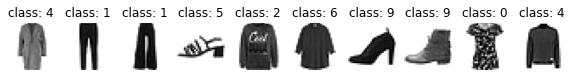

In [5]:
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title("class: " + str(y_train[i].item()))
    plt.axis("off")

## 2.4 MLP 모델 구성하기

In [6]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
#         output = F.log_softmax(logits, dim=1)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## 2.6 모델 매개변수 설정하기

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 2.7 학습 구성하기

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## 2.8 학습 모델 성능 확인하기

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 2.9 학습 진행하기

In [ ]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298872  [    0/60000]
loss: 2.255855  [16000/60000]
loss: 2.199771  [32000/60000]


# 3. TensorBoard로 학습된 모델 평가하기


https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html